<a href="https://colab.research.google.com/github/kimys0279/NCSU/blob/main/ECE542/Copy_of_ECE542_Hw03a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Convolutional Neural Networks**

In this notebook, we will explore some of the basic tools for regularization and hyper-parameter tuning for neural networks.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load and Splitting Data

We Will make use of the CIFAR10 dataset.

In [ ]:
# Loading train and test dataset
(trainingX, trainingY), (testX, testY) = cifar10.load_data()
labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Keeping 20% for Validation
valid_set_pc = 0.2
split= int((len(trainingX))*(1-valid_set_pc))

validX = trainingX[split:]
validY = trainingY[split:]

trainX = trainingX[:split]
trainY = trainingY[:split]

170500096/170498071 [==============================] - 2s 0us/step


ship


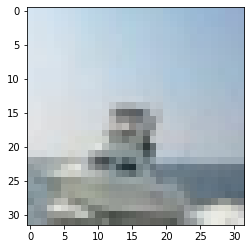

In [ ]:
# Showing a samples from the dataset
sampleID = 100
plt.imshow(trainX[sampleID])
print(labels[trainY[sampleID][0]])

In [ ]:
# Convert from integers to floats
trainingX = trainingX.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
testX  = testX.astype('float32')

# Normalize to range 0-1
trainingX = trainingX / 255.0
trainX = trainX / 255.0
validX = validX / 255.0
testX  = testX / 255.0

# One-hot encoding of outputs
trainingY = to_categorical(trainingY)
trainY = to_categorical(trainY)
validY = to_categorical(validY)
testY  = to_categorical(testY)

## Training a Base CNN Model

In [ ]:
# Defining Base CNN Model
def define_base_model():
	model = Sequential()
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(10, activation='softmax'))
 
	return model

# Creating an instance
base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [ ]:
# Training base model
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Epoch 1/15
1250/1250 [==============================] - 45s 10ms/step - loss: 2.1717 - accuracy: 0.2053 - val_loss: 1.8253 - val_accuracy: 0.3595
Epoch 2/15
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7497 - accuracy: 0.3746 - val_loss: 1.5396 - val_accuracy: 0.4517
Epoch 3/15
1250/1250 [==============================] - 12s 9ms/step - loss: 1.5072 - accuracy: 0.4647 - val_loss: 1.4173 - val_accuracy: 0.4897
Epoch 4/15
1250/1250 [==============================] - 12s 9ms/step - loss: 1.3772 - accuracy: 0.5083 - val_loss: 1.2932 - val_accuracy: 0.5459
Epoch 5/15
1250/1250 [==============================] - 12s 9ms/step - loss: 1.2612 - accuracy: 0.5519 - val_loss: 1.2112 - val_accuracy: 0.5769
Epoch 6/15
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1765 - accuracy: 0.5827 - val_loss: 1.1499 - val_accuracy: 0.5920
Epoch 7/15
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0720 - accuracy: 0.6224 - val_loss: 1.0882 - val_a

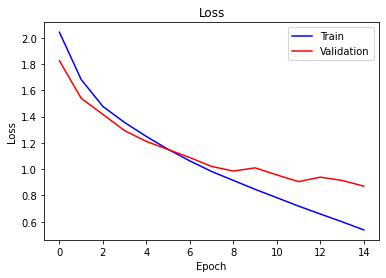

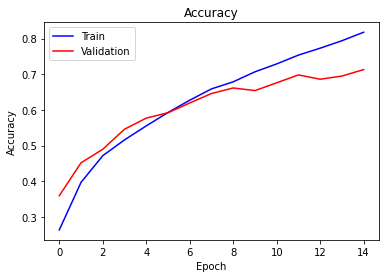

In [ ]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  
plot_history(base_history)

# **[Task 1] Comparing Optimizers**

The goal of of this section is to compare the performance of various optimizers: SGD with momentum, RMS Prop and Adam. Make sure you complete the following steps:

1. Train the network with SGB with momentum
2. Train the network with RMS Prop
3. Train the network with Adam
4. Create two plots showing accuracy for the training and validation sets
5. Comment on the performance of each optimizer. Which one had the steepest learning curve? Which one gave the final best performance? 




In [ ]:
# TODO - Training model with momentum 
def define_base_model():
	model = Sequential()
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(10, activation='softmax'))
 
	return model


base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=SGD(momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [ ]:
# TODO - Training model with RMS Prop
def define_base_model():
	model = Sequential()
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(10, activation='softmax'))
 
	return model


base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [ ]:
# TODO - Training model with Adam
def define_base_model():
	model = Sequential()
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(10, activation='softmax'))
 
	return model


base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)             

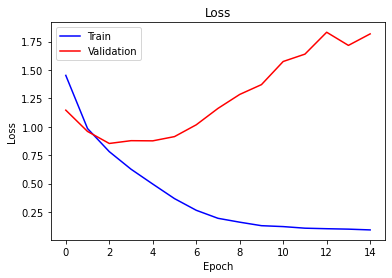

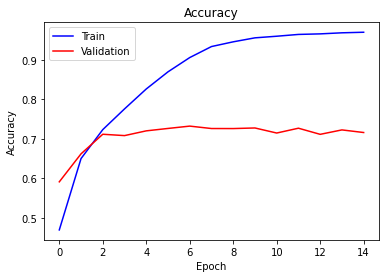

In [ ]:
# TODO - Plotting training accuracy

def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  
plot_history(base_history)

[TODO - Add your observations]



# **[Task 2] Applying Standard Regularization**

The goal of this section is to compare the effect of different normalization approaches including Batch normalization and Dropout. Make sure to complete the following steps:

1. Create a new model by adding a batch normalization layer after each convolutional layer and between the dense layers of the base model. Train it using the Adam optimizer.
2. Create a new model by adding dropout after each convolutional layer and between the dense layers of the base model with a rate equal to $0.2$. Train it using the Adam optimizer.
3. Create two plots showing accuracy for the training and validation sets comparing the regularized versions against the base model trained with the Adam optimizer.
4. Comment on the performance of each model. Which one had the steepest learning curve? Which one gave the final best performance? 




In [ ]:
# TODO - Defining Batch Normalization model and training it
def define_adam_model():
  model = Sequential()

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

base_model = define_adam_model()
base_model.summary()
base_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
# TODO - Defining dropout regularized model and training it

# layer = tf.keras.layers.Dropout(.2, input_shape=(2,))
# outputs = layer(data, training=True)
# keras.layers.Dropout(rate, noise_shape=None, seed=None)
from keras.layers import Dropout

def define_adam_model():
  model = Sequential()

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

base_model = define_adam_model()
base_model.summary()
base_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

# TODO - Defining dropout regularized model and training it
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(30,  activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	sgd = SGD(lr=0.01, momentum=0.8)
	model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
	return model
 
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, trainX, trainY, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

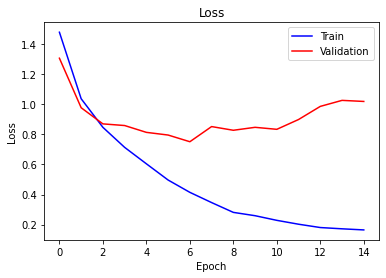

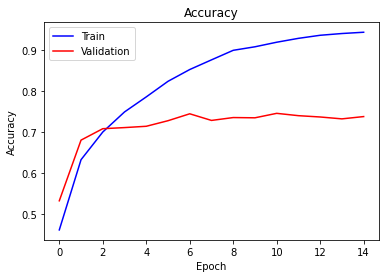

In [ ]:
# TODO - Plotting training accuracy
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  
plot_history(base_history)

[TODO - Add your observations]

# **[Task 3] Hyperparameter Tuning**

The objective of this section is to perform hyperparameter tuning of the network using a grid search. Make sure to complete these steps:

1. Perform a grid search for the optimal hyperparameters for the model with dropout regularization and Adam optimizer using the dropout values [0.1, 0.2, 0.3] and the learning rate values [0.1, 0.01, 0.001].
2. Display the results for the best model on the test dataset.

In [ ]:
# TODO - Defining final model for optimization
from keras.layers import Dropout

def define_adam_model():
  model = Sequential()

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

base_model = define_adam_model()
base_model.summary()
base_model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
from keras.layers import Dropout

def define_adam_model():
  model = Sequential()

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

base_model = define_adam_model()
base_model.summary()
base_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
from keras.layers import Dropout

def define_adam_model():
  model = Sequential()

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  return model

base_model = define_adam_model()
base_model.summary()
base_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 256)        

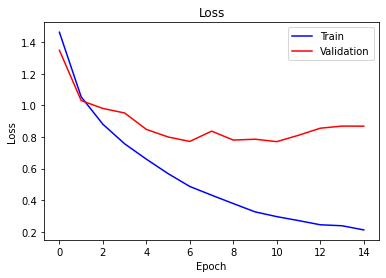

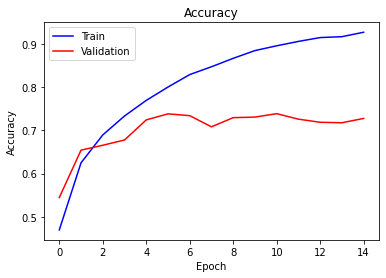

In [ ]:
# TODO - Displaying best parameters found
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  
plot_history(base_history)